> Purpose

Produce graphics that show audience about the tropical cyclones (TC) risk for PH. With a focus on TC induced rainfall, rapid intensification, storm surge, and the change in future climate.


> Data source

Track

IBTRACS

https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r01/access/shapefile/IBTrACS.WP.list.v04r01.lines.zip

https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r01/access/shapefile/IBTrACS.WP.list.v04r01.points.zip



# **Annual count of impacting (100km ring) and landfall TCs over PH. Three categories:**
# Major TC (CAT 4&5)
# Typhoons (CAT 1-5)
# All TCs (Tropical Storm + CAT 1-5)


# Step 0 : Import the library

In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
import warnings
warnings.filterwarnings('ignore')

# Step 1: Load the data

In [ ]:
tc_points = gpd.read_file("IBTrACS.WP.list.v04r01.points.shp")
lines = gpd.read_file("IBTrACS.WP.list.v04r01.lines.shp")
phl_buffer = gpd.read_file("PHL_1degree_buffer.shp")
phl_land = gpd.read_file("PHL_adm0.shp")

# Step 2: Preporcess the data with 1951-2024

In [ ]:
tc_points = tc_points[(tc_points['SEASON'] >= 1951) & (tc_points['SEASON'] <= 2025)]

# Step 2.1: Test which agency have most complete information in wind speed



To see TOK, KMA, HKO which one have the most complete information in wind speed
As the data set does not include PAGASA, local agency in PHL

In [ ]:
tok_wind_count = tc_points['TOK_WIND'].notnull().sum()
hko_wind_count = tc_points['HKO_WIND'].notnull().sum()
kma_wind_count = tc_points['KMA_WIND'].notnull().sum()

total_rows = len(tc_points)

print(f"Total number of records: {total_rows}")
print(f"Non-null TOK_WIND (JMA) values: {tok_wind_count} ({tok_wind_count/total_rows*100:.2f}%)")
print(f"Non-null HKO_WIND (HKO) values: {hko_wind_count} ({hko_wind_count/total_rows*100:.2f}%)")
print(f"Non-null KMA_WIND (KMA) values: {kma_wind_count} ({kma_wind_count/total_rows*100:.2f}%)")

# Determine which agency has the most complete data
wind_counts = {
    'JMA (Tokyo)': tok_wind_count,
    'HKO': hko_wind_count,
    'KMA': kma_wind_count
}
most_complete = max(wind_counts, key=wind_counts.get)
print(f"\nAgency with the most complete wind speed data: {most_complete} ({wind_counts[most_complete]} non-null values)")

Total number of records: 177074
Non-null TOK_WIND (JMA) values: 50168 (28.33%)
Non-null HKO_WIND (HKO) values: 82729 (46.72%)
Non-null KMA_WIND (KMA) values: 10561 (5.96%)

Agency with the most complete wind speed data: HKO (82729 non-null values)


To see all agency which one have the most complete information in wind speed
As the data set does not include PAGASA, local agency in PHL

In [ ]:
import pandas as pd

# Assuming tc_points is the DataFrame containing the dataset
# List of wind speed columns for all agencies/datasets
wind_columns = [
    'WMO_WIND', 'USA_WIND', 'TOK_WIND', 'CMA_WIND', 'HKO_WIND', 'KMA_WIND',
    'NEW_WIND', 'REU_WIND', 'BOM_WIND', 'NAD_WIND', 'WEL_WIND', 'DS8_WIND',
    'TD6_WIND', 'TD5_WIND', 'NEU_WIND', 'MLC_WIND'
]

# Count non-null values for each wind speed column
wind_counts = {col: tc_points[col].notnull().sum() for col in wind_columns}

# Total number of rows for context
total_rows = len(tc_points)

# Print results
print(f"Total number of records: {total_rows}")
for col, count in wind_counts.items():
    agency = col.replace('_WIND', '')
    percentage = (count / total_rows * 100) if total_rows > 0 else 0
    print(f"Non-null {agency} wind speed values: {count} ({percentage:.2f}%)")


Total number of records: 177074
Non-null WMO wind speed values: 29693 (16.77%)
Non-null USA wind speed values: 126378 (71.37%)
Non-null TOK wind speed values: 50168 (28.33%)
Non-null CMA wind speed values: 127350 (71.92%)
Non-null HKO wind speed values: 82729 (46.72%)
Non-null KMA wind speed values: 10561 (5.96%)
Non-null NEW wind speed values: 410 (0.23%)
Non-null REU wind speed values: 0 (0.00%)
Non-null BOM wind speed values: 0 (0.00%)
Non-null NAD wind speed values: 0 (0.00%)
Non-null WEL wind speed values: 0 (0.00%)
Non-null DS8 wind speed values: 43128 (24.36%)
Non-null TD6 wind speed values: 55482 (31.33%)
Non-null TD5 wind speed values: 35065 (19.80%)
Non-null NEU wind speed values: 0 (0.00%)
Non-null MLC wind speed values: 0 (0.00%)


# Step 3: Categorize TCs based on maximum wind speed

According to Saffir-Simpson Hurricane Scale
* Tropical depression : wind < 34
* Tropical storm : 34 < wind < 64
* Category 1 : 64 <= wind < 83
* Category 2 : 83 <= wind < 96
* Category 3 : 96 <= wind < 113
* Category 4 : 113 <= wind < 137
* Category 5 : wind >= 137

* All TCs = Tropical Storm + CAT 1-5


In [ ]:
def categorize_tc(wind):
    if pd.isna(wind):
        return None
    if wind >= 137:
        return 'Category 5'
    elif wind >= 113:
        return 'Category 4'
    elif wind >= 96:
        return 'Category 3'
    elif wind >= 83:
        return 'Category 2'
    elif wind >= 64:
        return 'Category 1'
    elif wind > 34:
        return 'Tropical Storm'
    return 'Tropical depression'

In [ ]:
tc_points['category'] = tc_points['USA_WIND'].apply(categorize_tc)

# Step 4: Aligns to CRS

Aligns the coordinate reference systems (CRS) of the two GeoDataFrames (tc_points and phl_buffer) to WGS84 (EPSG:4326), a standard geographic CRS using latitude and longitude in degrees

In [ ]:
tc_points = tc_points.to_crs(epsg=4326)
phl_buffer = phl_buffer.to_crs(epsg=4326)
phl_land = phl_land.to_crs(epsg=4326)

# Step 5: Performs a spatial join between tc_points and phl_buffer using GeoPandas


Performs a spatial join between tc_points and phl_buffer using GeoPandas

Only the geometry column of phl_buffer is used to avoid including unnecessary columns

Keeps only the rows from tc_points where the point’s geometry is within the buffer’s geometry, discarding points outside the buffer.

Specifies that a point must be fully inside the buffer polygon to be considered impacting

***Output***: impacting_points is a new GeoDataFrame containing only the TC points within the 1 degree, retaining all columns from tc_points (e.g., SID, year, category, wind_knots) plus an index_right column indicating the matching buffer polygon (if multiple polygons exist in phl_buffer).

In [ ]:
impacting_points = gpd.sjoin(tc_points, phl_buffer[['geometry']], how='inner', predicate='within')

In [ ]:
landfall_points = gpd.sjoin(tc_points, phl_land[['geometry']], how='inner', predicate='intersects')

It checks the category column (created in Step 2 based on wind speeds) and returns the highest category present, prioritizing Major TC > Typhoon > Tropical Storm.

In [ ]:
print(landfall_points.columns)
print(landfall_points[['SID', 'year', 'category']])

print(impacting_points.columns)
print(impacting_points[['SID', 'year', 'category']])


Index(['SID', 'SEASON', 'NUMBER', 'BASIN', 'SUBBASIN', 'NAME', 'ISO_TIME',
       'NATURE', 'LAT', 'LON',
       ...
       'STORM_SPD', 'STORM_DR', 'year', 'month', 'day', 'hour', 'min',
       'geometry', 'category', 'index_right'],
      dtype='object', length=182)
                  SID  year        category
68324   1951119N06145  1951      Category 2
68325   1951119N06145  1951      Category 1
68333   1951119N06145  1951  Tropical Storm
68334   1951119N06145  1951  Tropical Storm
68770   1951203N08136  1951            None
...               ...   ...             ...
245050  2024313N15138  2024      Category 1
245051  2024313N15138  2024      Category 1
245052  2024313N15138  2024      Category 1
245128  2024314N07151  2024      Category 4
245129  2024314N07151  2024      Category 3

[1890 rows x 3 columns]
Index(['SID', 'SEASON', 'NUMBER', 'BASIN', 'SUBBASIN', 'NAME', 'ISO_TIME',
       'NATURE', 'LAT', 'LON',
       ...
       'STORM_SPD', 'STORM_DR', 'year', 'month', 'day', 'hour

# Step 6: Determines the highest intensity category for a group of TC points


In [ ]:
def get_max_category(group):
    categories = ['Category 5','Category 4','Category 3','Category 2','Category 1','Tropical Storm','Tropical depression']
    for cat in categories:
        if cat in group['category'].values:
            return cat

# Step 7: Counting the impacting number

1: reset_index().rename(columns={0: 'category'}): Converts the grouped result (a Series with SID and year as indices) to a DataFrame, naming the category column.

2: Removes TCs with no valid category (e.g., due to missing wind data).

3: Counts the number of TCs per year and category, creating a DataFrame (impacting_counts) with years as rows and categories as columns, filled with zeros for missing categories.

In [ ]:
# Impacting TCs
impacting_tcs = impacting_points.groupby(['SID', 'year']).apply(get_max_category).reset_index().rename(columns={0: 'category'})
impacting_tcs = impacting_tcs[impacting_tcs['category'].notnull()]
impacting_counts = impacting_tcs.groupby(['year', 'category']).size().unstack(fill_value=0)

In [ ]:
impacting_counts

category,Category 1,Category 2,Category 3,Category 4,Category 5,Tropical Storm,Tropical depression
year,,,,,,,
1951,1,2,2,1,0,0,1
1952,3,2,1,2,1,2,1
1953,1,0,1,1,0,2,1
1954,0,1,3,1,1,2,0
1955,1,0,0,1,0,1,1
...,...,...,...,...,...,...,...
2020,0,1,2,0,1,2,6
2021,1,0,0,0,2,2,5
2022,1,0,0,1,0,3,2


# Step 8: Counting the landfall number

In [ ]:
# Landfall TCs
landfall_tcs = landfall_points.groupby(['SID', 'year']).apply(get_max_category).reset_index().rename(columns={0: 'category'})
landfall_tcs = landfall_tcs[landfall_tcs['category'].notnull()]
landfall_counts = landfall_tcs.groupby(['year', 'category']).size().unstack(fill_value=0)

In [ ]:
impacting_counts.columns

Index(['Category 1', 'Category 2', 'Category 3', 'Category 4', 'Category 5',
       'Tropical Storm', 'Tropical depression'],
      dtype='object', name='category')

In [ ]:
landfall_counts

category,Category 1,Category 2,Category 3,Category 4,Category 5,Tropical Storm,Tropical depression
year,,,,,,,
1951,1,3,1,0,0,0,1
1952,2,1,1,1,1,2,1
1953,0,1,0,0,0,2,1
1954,3,0,0,0,1,2,0
1955,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...
2020,1,1,1,0,1,1,5
2021,0,0,0,1,0,1,6
2022,1,0,0,1,0,2,0


# Step 9: divide into three section og landfall and impacting

*   All TCs = Tropical Storm + CAT 1-5
*   Typhoons (CAT 1-5)
*   Major TC (CAT 4&5)



In [ ]:
# Ensure all categories are present
for cat in ['Category 5','Category 4','Category 3','Category 2','Category 1','Tropical Storm','Tropical depression']:
    if cat not in impacting_counts.columns:
        impacting_counts[cat] = 0
    if cat not in landfall_counts.columns:
        landfall_counts[cat] = 0

# Compute All TCs (sum of Tropical Storm and CAT 1-5 )
impacting_counts['All TCs'] = impacting_counts[['Category 5','Category 4','Category 3','Category 2','Category 1','Tropical Storm']].sum(axis=1)
landfall_counts['All TCs']  = landfall_counts[['Category 5','Category 4','Category 3','Category 2','Category 1','Tropical Storm']].sum(axis=1)

impacting_counts['Major TCs'] = impacting_counts[['Category 5','Category 4']].sum(axis=1)
landfall_counts['Major TCs']  = landfall_counts[['Category 5','Category 4']].sum(axis=1)

impacting_counts['Typhoons (CAT 1-5)'] = impacting_counts[['Category 5','Category 4','Category 3','Category 2','Category 1']].sum(axis=1)
landfall_counts['Typhoons (CAT 1-5)']  = landfall_counts[['Category 5','Category 4','Category 3','Category 2','Category 1']].sum(axis=1)


# Reorder columns
categories = ['All TCs','Major TCs','Typhoons (CAT 1-5)']
impacting_counts = impacting_counts[categories]
landfall_counts = landfall_counts[categories]

In [ ]:
landfall_counts

category,All TCs,Major TCs,Typhoons (CAT 1-5)
year,,,
1951,5,0,5
1952,8,2,6
1953,3,0,1
1954,6,1,4
1955,3,1,2
...,...,...,...
2020,5,1,4
2021,2,1,1
2022,4,1,2


In [ ]:
impacting_counts

category,All TCs,Major TCs,Typhoons (CAT 1-5)
year,,,
1951,6,1,6
1952,11,3,9
1953,5,1,3
1954,8,2,6
1955,3,1,2
...,...,...,...
2020,6,1,4
2021,5,2,3
2022,5,1,2


In [ ]:
# Save results to CSV
impacting_counts.to_csv('impacting_tc_counts.csv')
landfall_counts.to_csv('landfall_tc_counts.csv')

# Step 10: Visualize results

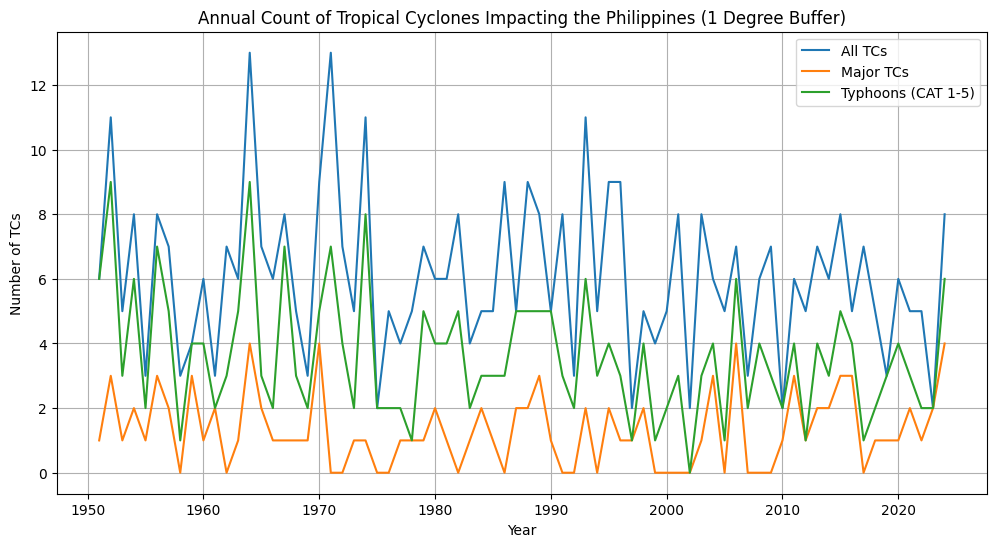

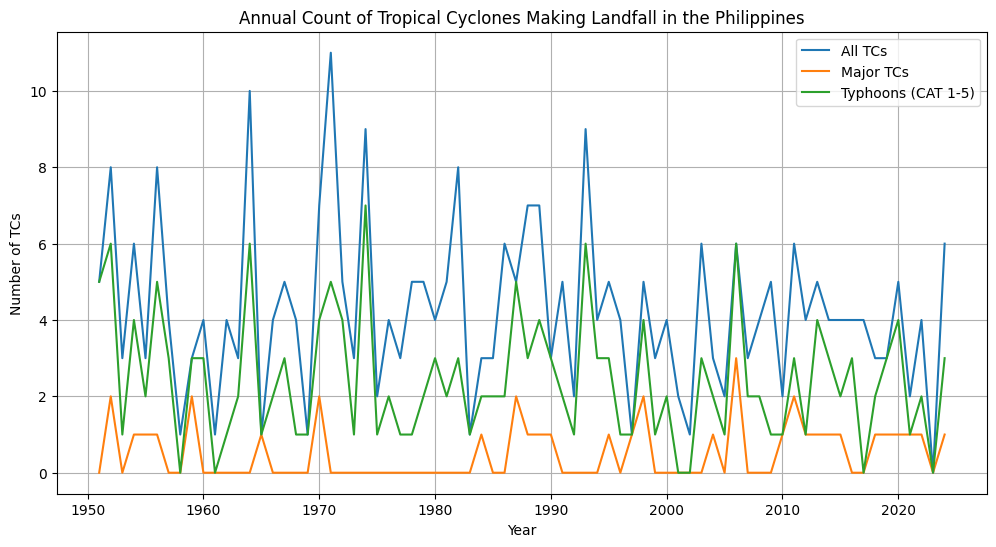

In [ ]:
# Visualize results
plt.figure(figsize=(12, 6))
for cat in categories:
    plt.plot(impacting_counts.index, impacting_counts[cat], label=cat)
plt.title('Annual Count of Tropical Cyclones Impacting the Philippines (1 Degree Buffer)')
plt.xlabel('Year')
plt.ylabel('Number of TCs')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
for cat in categories:
    plt.plot(landfall_counts.index, landfall_counts[cat], label=cat)
plt.title('Annual Count of Tropical Cyclones Making Landfall in the Philippines')
plt.xlabel('Year')
plt.ylabel('Number of TCs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Print summary statistics
print("Impacting TCs (1951–2024):")
print(impacting_counts.mean())
print("\nLandfall TCs (1951–2024):")
print(landfall_counts.mean())

Impacting TCs (1951–2024):
category
All TCs               6.081081
Major TCs             1.310811
Typhoons (CAT 1-5)    3.594595
dtype: float64

Landfall TCs (1951–2024):
category
All TCs               4.243243
Major TCs             0.500000
Typhoons (CAT 1-5)    2.432432
dtype: float64


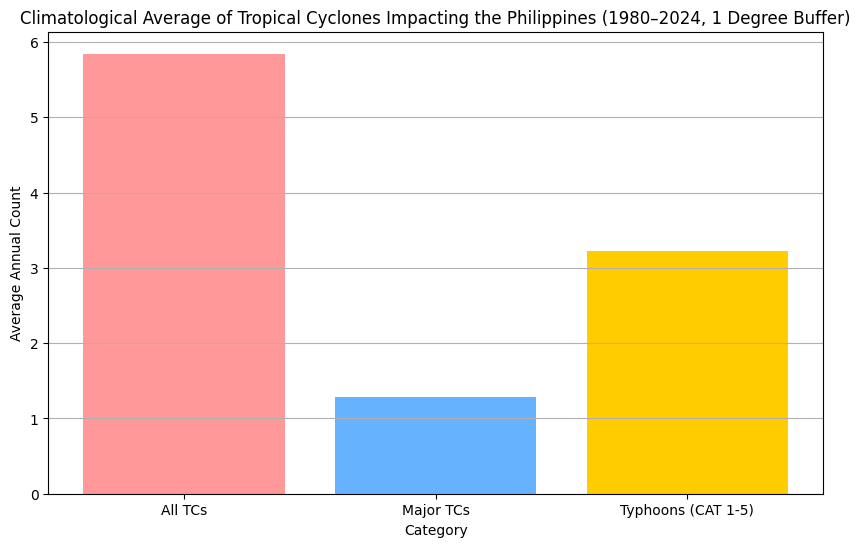

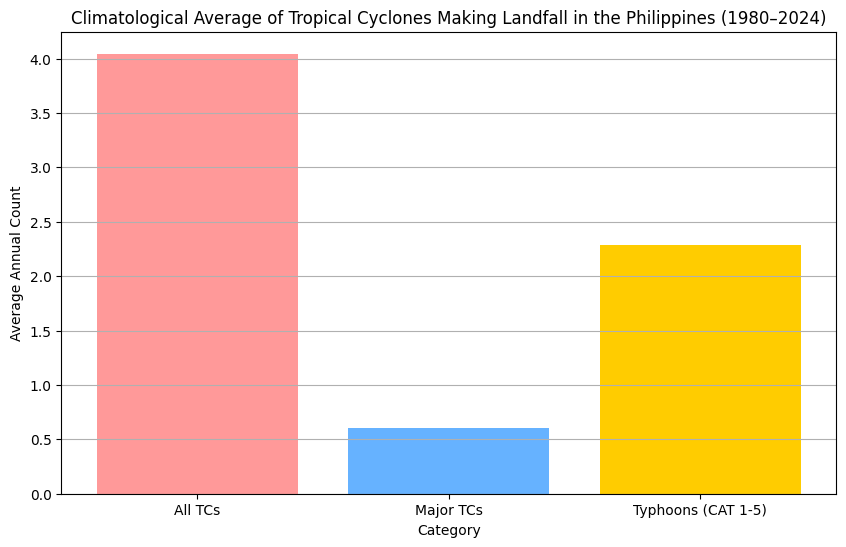

In [ ]:
impacting_counts_1980_2024 = impacting_counts[impacting_counts.index >= 1980]
landfall_counts_1980_2024 = landfall_counts[landfall_counts.index >= 1980]

# Compute climatological averages
impacting_avg = impacting_counts_1980_2024.mean()
landfall_avg = landfall_counts_1980_2024.mean()

# Bar plot for impacting TCs
plt.figure(figsize=(10, 6))
x = range(len(categories))
plt.bar(x, impacting_avg, color=['#FF9999', '#66B2FF', '#FFCC00'])
plt.xticks(x, categories)
plt.title('Climatological Average of Tropical Cyclones Impacting the Philippines (1980–2024, 1 Degree Buffer)')
plt.xlabel('Category')
plt.ylabel('Average Annual Count')
plt.grid(True, axis='y')
plt.savefig('impacting_avg_bar.png')
plt.show()

# Bar plot for landfall TCs
plt.figure(figsize=(10, 6))
plt.bar(x, landfall_avg, color=['#FF9999', '#66B2FF', '#FFCC00'])
plt.xticks(x, categories)
plt.title('Climatological Average of Tropical Cyclones Making Landfall in the Philippines (1980–2024)')
plt.xlabel('Category')
plt.ylabel('Average Annual Count')
plt.grid(True, axis='y')
plt.savefig('landfall_avg_bar.png')
plt.show()

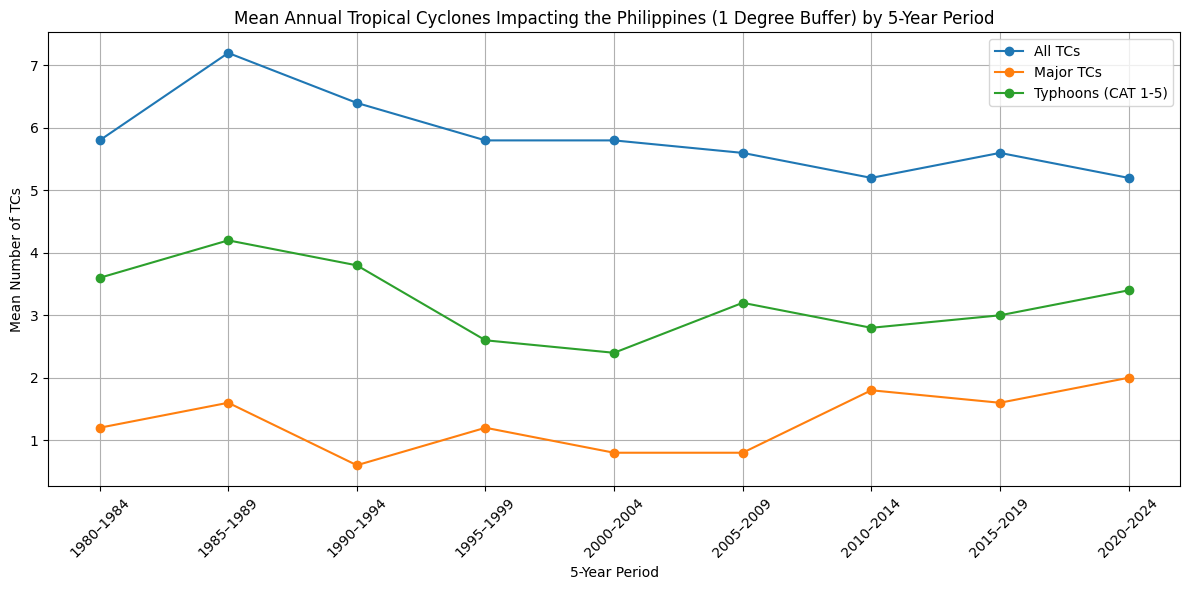

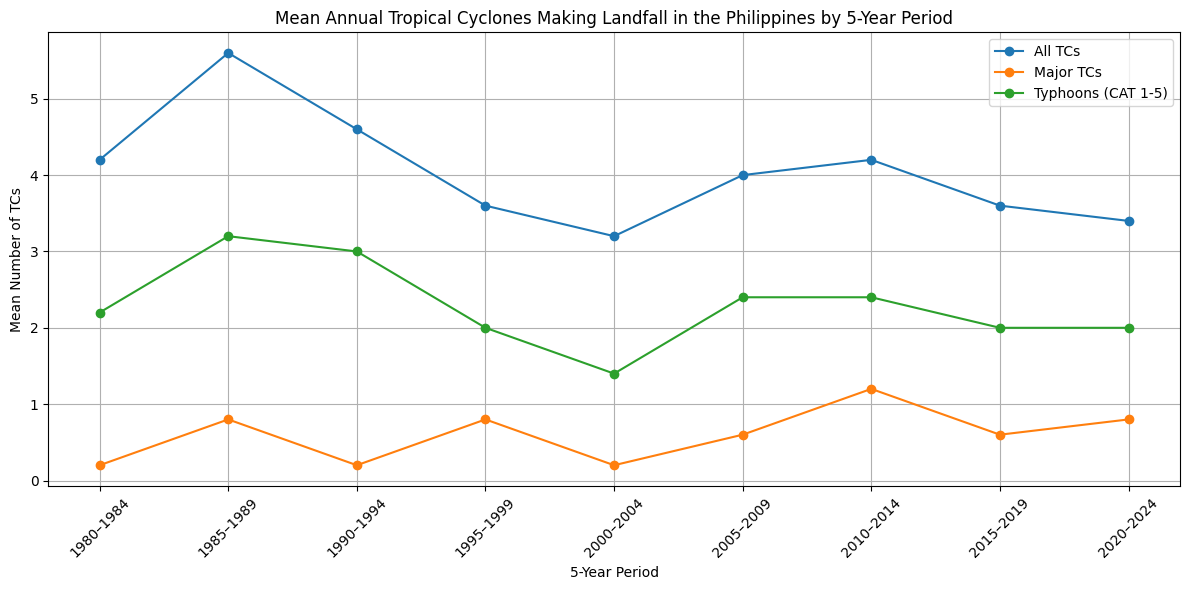

In [ ]:
# Step 5: Compute 5-year period means (1980–2024)
# Define 5-year periods
periods = [
    (1980, 1984), (1985, 1989), (1990, 1994), (1995, 1999),
    (2000, 2004), (2005, 2009), (2010, 2014), (2015, 2019),
    (2020, 2024)
]
period_labels = [f"{start}–{end}" for start, end in periods]

# Filter for 1980–2024
impacting_counts = impacting_counts.loc[1980:2024]
landfall_counts = landfall_counts.loc[1980:2024]

# Compute means for each period
impacting_means = []
landfall_means = []
for start, end in periods:
    period_data_impacting = impacting_counts.loc[start:end].mean()
    period_data_landfall = landfall_counts.loc[start:end].mean()
    impacting_means.append(period_data_impacting)
    landfall_means.append(period_data_landfall)

# Convert to DataFrames
impacting_means_df = pd.DataFrame(impacting_means, index=period_labels)
landfall_means_df = pd.DataFrame(landfall_means, index=period_labels)

# Visualize 5-year period means
# Plot impacting TCs
plt.figure(figsize=(12, 6))
for cat in categories:
    plt.plot(period_labels, impacting_means_df[cat], label=cat, marker='o')
plt.title('Mean Annual Tropical Cyclones Impacting the Philippines (1 Degree Buffer) by 5-Year Period')
plt.xlabel('5-Year Period')
plt.ylabel('Mean Number of TCs')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot landfall TCs
plt.figure(figsize=(12, 6))
for cat in categories:
    plt.plot(period_labels, landfall_means_df[cat], label=cat, marker='o')
plt.title('Mean Annual Tropical Cyclones Making Landfall in the Philippines by 5-Year Period')
plt.xlabel('5-Year Period')
plt.ylabel('Mean Number of TCs')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


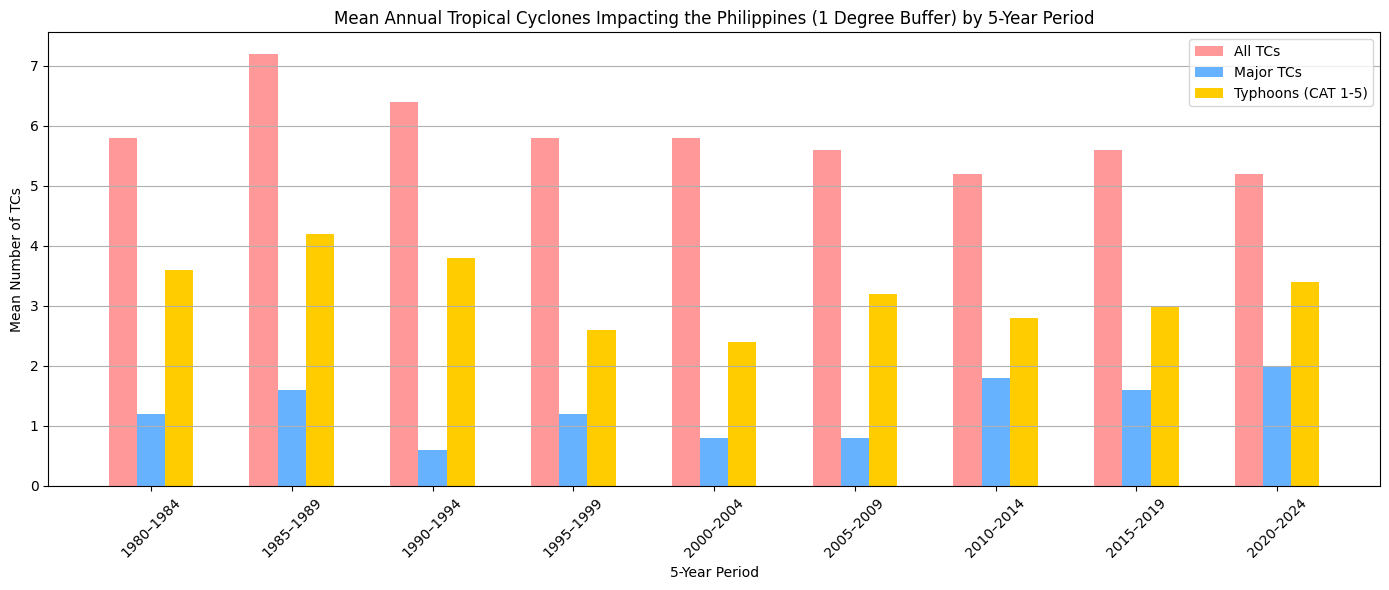

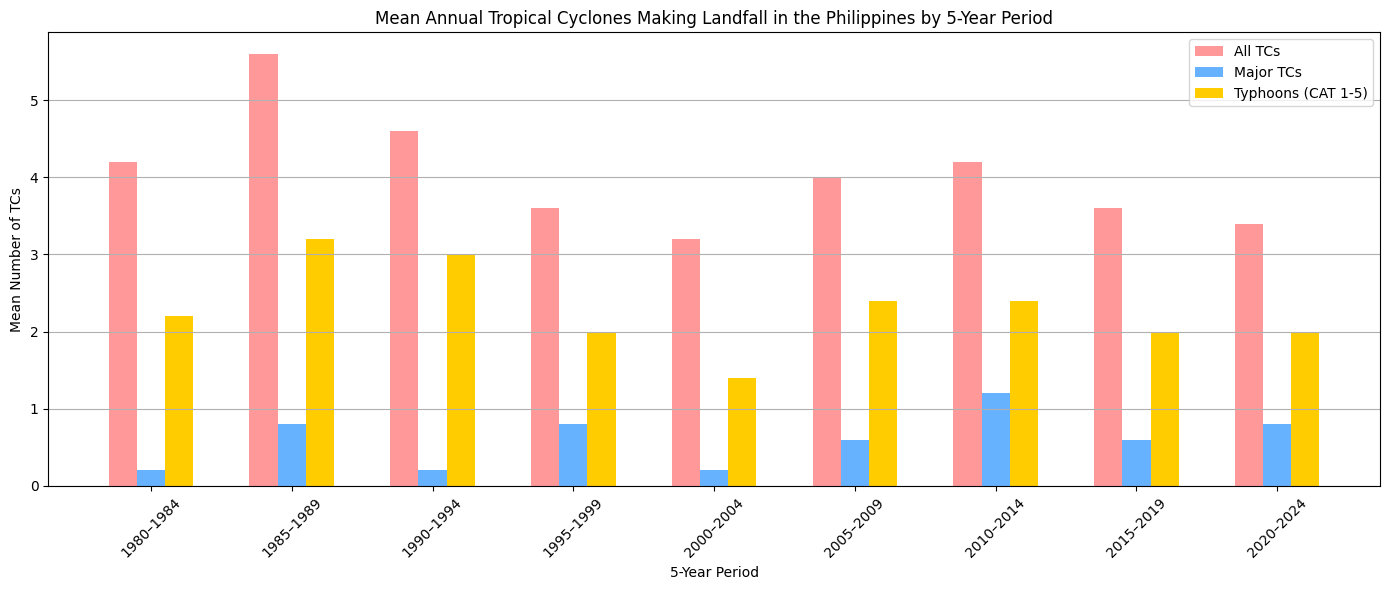

In [ ]:
# Visualize 5-year period means as bar charts
# Plot impacting TCs
plt.figure(figsize=(14, 6))
bar_width = 0.2  # Width of each bar
x = np.arange(len(period_labels))  # Positions for periods
colors = ['#FF9999', '#66B2FF', '#FFCC00', '#99CC99']  # Colors for categories

for i, cat in enumerate(categories):
    plt.bar(x + i * bar_width, impacting_means_df[cat], bar_width, label=cat, color=colors[i])

plt.title('Mean Annual Tropical Cyclones Impacting the Philippines (1 Degree Buffer) by 5-Year Period')
plt.xlabel('5-Year Period')
plt.ylabel('Mean Number of TCs')
plt.xticks(x + bar_width * (len(categories) - 1) / 2, period_labels, rotation=45)
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# Plot landfall TCs
plt.figure(figsize=(14, 6))
for i, cat in enumerate(categories):
    plt.bar(x + i * bar_width, landfall_means_df[cat], bar_width, label=cat, color=colors[i])

plt.title('Mean Annual Tropical Cyclones Making Landfall in the Philippines by 5-Year Period')
plt.xlabel('5-Year Period')
plt.ylabel('Mean Number of TCs')
plt.xticks(x + bar_width * (len(categories) - 1) / 2, period_labels, rotation=45)
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# **Fun fact:**

1: Nearest location to land within next 6 hours

This can be thought of a landfall flag

(=0 -- Landfall within 6 hours.)

(>0 -- No landfall within next 6 hours.)

Calculations are based on storm center

2: in 2023, there are no typhoon direct landfall in philippines, which show a sharp drop in the plotting

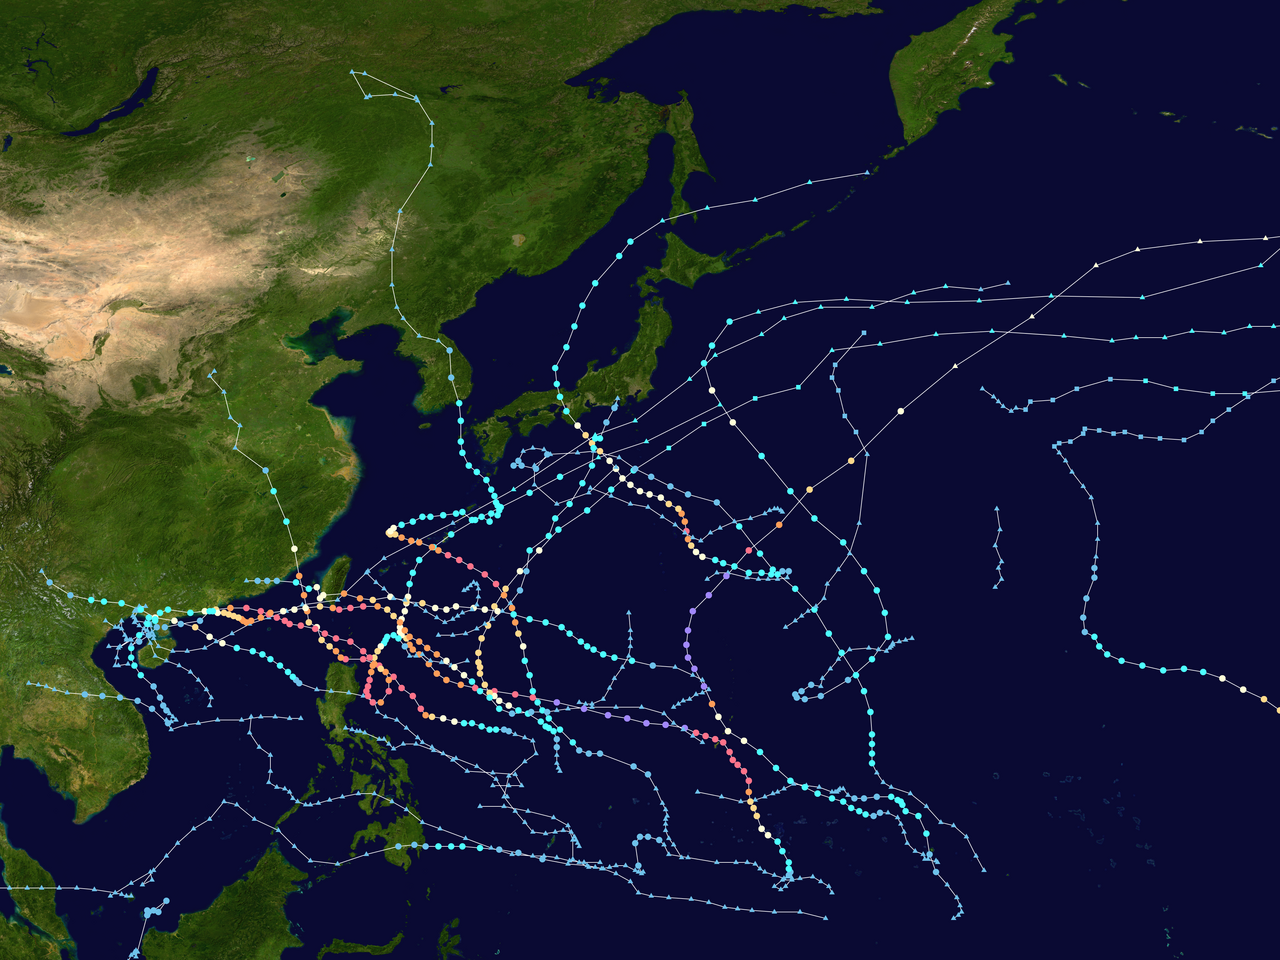

In [ ]:
# Check if 2023 exists in the 'year' column
is_2023_present = 2023 in landfall_points['SEASON'].values
print("Is 2023 present in the DataFrame? ", is_2023_present)

# If 2023 exists, filter and display rows for 2023
if is_2023_present:
    print("\nRows for year 2023:")
    print(landfall_points[landfall_points['SEASON'] == 2023][['SID','NAME','ISO_TIME' ,'SEASON', 'category']])
else:
    print("No data for year 2023 found in the DataFrame.")

Is 2023 present in the DataFrame?  True

Rows for year 2023:
                  SID     NAME             ISO_TIME  SEASON  \
241669  2023101N14127  UNNAMED  2023-04-11 15:00:00    2023   
241670  2023101N14127  UNNAMED  2023-04-11 18:00:00    2023   
241673  2023101N14127  UNNAMED  2023-04-12 03:00:00    2023   
241676  2023101N14127  UNNAMED  2023-04-12 12:00:00    2023   
241677  2023101N14127  UNNAMED  2023-04-12 15:00:00    2023   
241678  2023101N14127  UNNAMED  2023-04-12 18:00:00    2023   
241679  2023101N14127  UNNAMED  2023-04-12 21:00:00    2023   
241681  2023101N14127  UNNAMED  2023-04-13 03:00:00    2023   
241682  2023101N14127  UNNAMED  2023-04-13 06:00:00    2023   
241992  2023194N16123    TALIM  2023-07-13 18:00:00    2023   
241993  2023194N16123    TALIM  2023-07-13 21:00:00    2023   
241994  2023194N16123    TALIM  2023-07-14 00:00:00    2023   
241995  2023194N16123    TALIM  2023-07-14 03:00:00    2023   
243360  2023349N04141  JELAWAT  2023-12-18 03:00:00    20

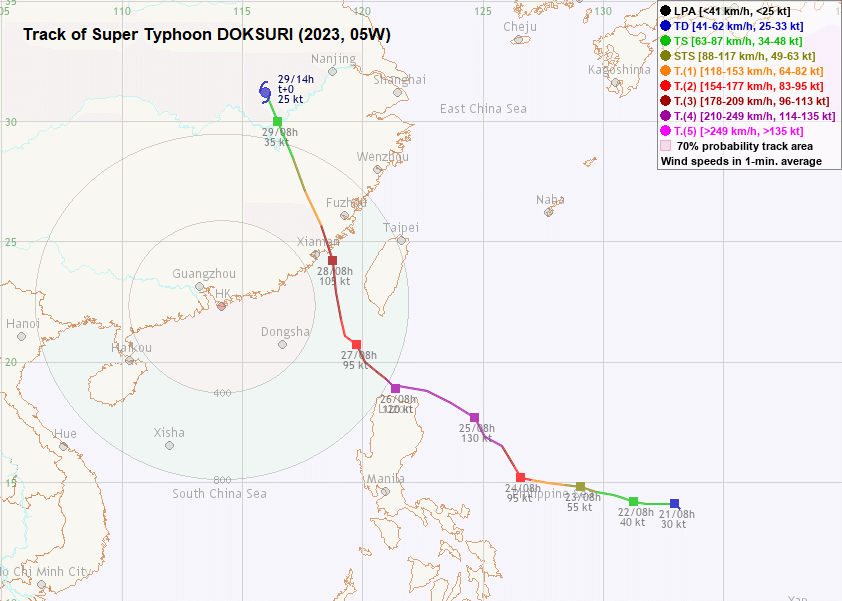

> ***Reference***



https://www.ncei.noaa.gov/products/international-best-track-archive

https://www.ncei.noaa.gov/sites/g/files/anmtlf171/files/2025-04/IBTrACS_version4r01_Technical_Details.pdf